## Exploratory Data Analysis (EDA) MIMIC-III v1.4

**Important**: make sure to follow the instructions in the ```!INSTRUCTIONS.MD``` file in the `mimic-iii` folder, prior to running the code cells below.

First, define the path to the MIMIC-III dataset created with MIMIC-CODE and the source code of (Roggeveen et al., 2021) over at [link](https://github.com/LucaMD/SRL). <br>

In [1]:
SRC_PATH = 'mimic-iii/final/'

... and list all dependencies:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

## Patient Demographics

In [3]:
demo_df = pd.read_csv(SRC_PATH + 'demographics_cohort.csv')

print('###' * 12)
print("Number of patients:", len(set(demo_df['subject_id'])))
print("Number of (hospital) admissions:", len(set(demo_df['hadm_id'])))
print("Number of (ICU) admissions:", len(set(demo_df['icustay_id'])))
print("Male (%):", sum(demo_df['is_male'] == 1) / len(demo_df))
print("Vent (%):", sum(demo_df['vent'] == 1) / len(demo_df))
print('###' * 12)

####################################
Number of patients: 60
Number of (hospital) admissions: 60
Number of (ICU) admissions: 60
Male (%): 0.4666666666666667
Vent (%): 0.45
####################################


C:\Users\UWNAAM~1\AppData\Local\Temp/ipykernel_13540/195235639.py:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  demo_df.hist(column=usecols, ax=ax);


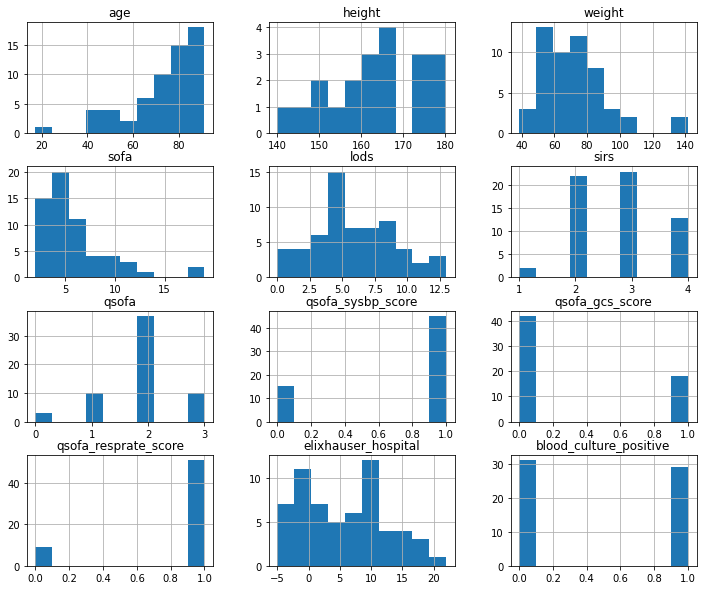

In [4]:
# Binary/continuous variables possibly of interest *excl. ethnicity)
usecols = ['age', 'height', 'weight', 'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score', 
           'qsofa_gcs_score', 'qsofa_resprate_score', 'elixhauser_hospital', 'blood_culture_positive']

# Plot histograms
fig = plt.figure(figsize=(12, 10))
ax = fig.gca()
demo_df.hist(column=usecols, ax=ax);

## Continuous Measurements: FiO2, Vitals, etc.

Many of the 'features' in the dataset are continuous measurements recorded over time in the patient record. Let's analyze one such patient;

In [30]:
# Sample a ICU admission to analyze
icustay_id = 290513
print('Analyzing ICU admission with ID =', icustay_id)

Analyzing ICU admission with ID = 290513


### FiO2 (Fraction of Inspired Oxygen)

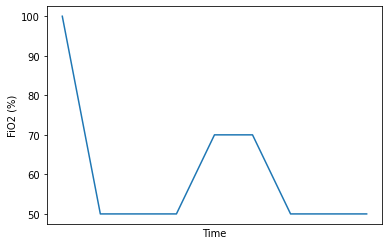

In [31]:
fio2 = pd.read_csv(SRC_PATH + 'fio2_cohort.csv')

# Limit to single admission
icustay_fio2 = fio2[fio2['icustay_id'] == icustay_id]

# One plot a day keeps the doctor away
plt.figure(figsize=(6, 4))
plt.plot(icustay_fio2['charttime'], icustay_fio2['fio2'])
plt.xlabel('Time')
plt.ylabel('FiO2 (%)')
plt.xticks([]);

### Urine Output

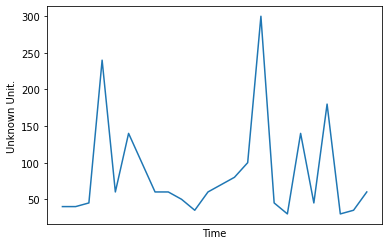

In [46]:
urine = pd.read_csv(SRC_PATH + 'urineoutput_cohort.csv')

# Limit to single admission
icustay_urine = urine[urine['icustay_id'] == icustay_id]

# One plot a day keeps the doctor away
plt.figure(figsize=(6, 4))
plt.plot(icustay_urine['charttime'], icustay_urine['value'])
plt.xlabel('Time')
plt.ylabel('Unknown Unit.')
plt.xticks([]);

### Vitals (Heart Rate, Respiratory Rate, Blood Pressure)

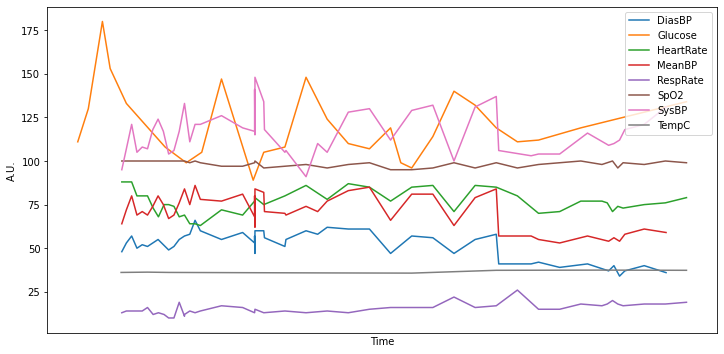

In [32]:
vitals = pd.read_csv(SRC_PATH + 'vitals_cohort.csv')

# Convert charttime to dtype DateTime
vitals['charttime'] = pd.to_datetime(vitals['charttime'])

# Limit to single admission
icustay_vitals = vitals[vitals['icustay_id'] == icustay_id]

# Plot each vital separately in the same plot
plt.figure(figsize=(12, 6))
for vital_id, vital_data in icustay_vitals.groupby('vital_id'):
    plt.plot(vital_data['charttime'], vital_data['valuenum'], label=vital_id)
plt.xlabel('Time')
plt.ylabel('A.U.')
plt.xticks([]);
plt.legend();

Note the difference in sampling rates between the blood pressure measurements (e.g. DiasBP, SysBP) and the measured Glucose and temperature levels!Also not that each series may start and end at different times.

### Vasopressors

#### CareVue Records

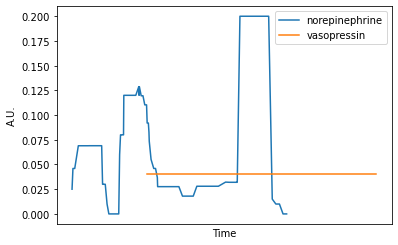

In [47]:
vaso_cv = pd.read_csv(SRC_PATH + 'vassopressors_cv_cohort.csv')

# Convert charttime to dtype DateTime
vaso_cv['charttime'] = pd.to_datetime(vaso_cv['charttime'])

# Limit to single admission
icustay_vaso_cv = vaso_cv[vaso_cv['icustay_id'] == 201006]  # different patient

# Two plots a day keeps the doctor away
plt.figure(figsize=(6, 4))
for vasoactive_drug, drug_data in icustay_vaso_cv.groupby('vasoactive_drug'):
    plt.plot(drug_data['charttime'], drug_data['rate'], label=vasoactive_drug)
plt.xlabel('Time')
plt.ylabel('A.U.')
plt.xticks([]);
plt.legend();

#### MetaVision Records

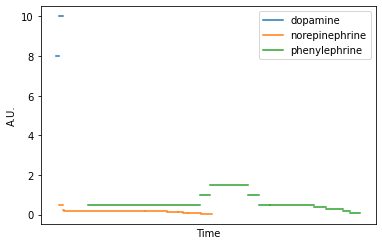

In [59]:
vaso_mv = pd.read_csv(SRC_PATH + 'vassopressors_mv_cohort.csv')

# Convert charttime to dtype DateTime
vaso_mv['starttime'] = pd.to_datetime(vaso_mv['starttime'])
vaso_mv['endtime'] = pd.to_datetime(vaso_mv['endtime'])

# Limit to single admission
icustay_vaso_mv = vaso_mv[vaso_mv['icustay_id'] == 210989]  # different patient again

# A dose of dopamine a day keeps the doctor away
plt.figure(figsize=(6, 4))
for i, (vasoactive_drug, drug_data) in enumerate(icustay_vaso_mv.groupby('vasoactive_drug')):
    # Plot each drug as line segments (between start- and endtime)
    for j, row in drug_data.reset_index().iterrows():
        plt.plot([row['starttime'], row['endtime']], 
                 [row['rate'], row['rate']], 
                 'C' + str(i),
                 label=vasoactive_drug if j == 0 else "")
plt.xlabel('Time')
plt.ylabel('A.U.')
plt.xticks([]);
plt.legend();

### Laboratory Results

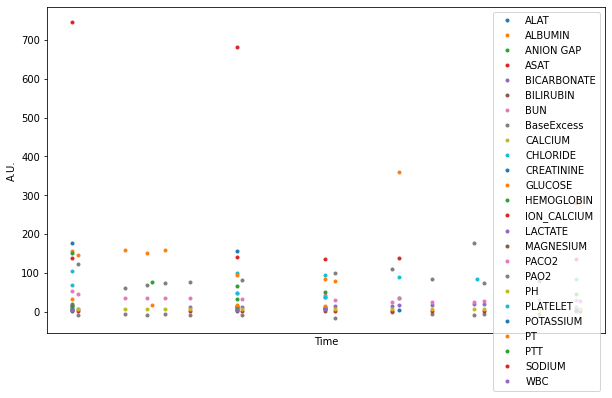

In [65]:
labs = pd.read_csv(SRC_PATH + 'labs_cohort.csv')

# Convert charttime to dtype DateTime
labs['charttime'] = pd.to_datetime(labs['charttime'])

# Limit to single admission
icustay_labs = labs[labs['icustay_id'] == 228977]

# A dose of dopamine a day keeps the doctor away
plt.figure(figsize=(10, 6))
for lab_id, lab_data in icustay_labs.groupby('lab_id'):
    # Plot each drug as line segments (between start- and endtime)
    plt.plot(lab_data['charttime'], lab_data['valuenum'], '.', label=lab_id)
plt.xlabel('Time')
plt.ylabel('A.U.')
plt.xticks([]);
plt.legend();

### Input Events

**TODO:** Correct time-axis

**TODO:** Find out meaning of these data (IV fluids?)


0   2164-10-24 06:00:00
1   2164-10-24 09:00:00
2   2164-10-24 18:00:00
3   2164-10-24 09:00:00
4   2164-10-24 12:00:00
5   2164-10-23 23:00:00
Name: charttime, dtype: datetime64[ns]


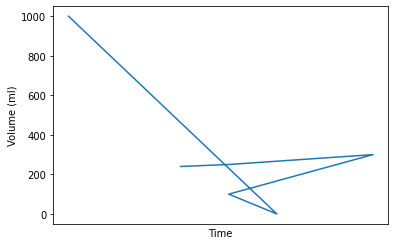

In [76]:
input_events = pd.read_csv(SRC_PATH + 'inputevents_cv_cohort.csv')

# Convert charttime to dtype DateTime
input_events['charttime'] = pd.to_datetime(input_events['charttime'])

# Limit to single admission
icustay_input_events = input_events[input_events['icustay_id'] == 206504]

plt.plot(icustay_input_events['charttime'], icustay_input_events['amount'])
plt.xlabel('Time')
plt.ylabel('Volume (ml)')
plt.xticks([]);